## Adding a real-time pipeline

Our goal is to introduce ML into content moderation. We want to train a model that will assign risk scores to content, so that human moderators will know which content is likely to be harmful and should be reviewed quickly. (For example: a user-uploaded image that contains violence and disturbing content, instead of delicious food items.)

We will score each image immediately when it is uploaded. However, since more information becomes available as time goes on (e.g. flags, comments, etc.) we will also want to re-score each image at additional anchor times, using signals like:

-   how many views arrived recently
-   how many comments arrived recently
-   how many flags arrived recently

<figure>
<img src="images/image-timeline.png" alt="Timeline of events related to one image." />
<figcaption aria-hidden="true">Timeline of events related to one image.</figcaption>
</figure>

Those time-anchored signals will be needed in two places:

-   inference: decide now whether content is safe, or whether it needs urgent review
-   training: help our model understand how to do better, given both the information known at inference time and the eventual moderation decision

Our current data repository, PostgreSQL is the transactional system of record for current application state, but querying it directly is not appropriate for inference *or* for training. First of all, using the serving database to compute features for real-time inference and for training will add extra load and potentially degrade the actual GourmetGram service. Second, the database tells us application state e.g. total views at the current time, but it doesn’t give us the time-anchored views that we will need for training (what was the recent view count at upload time? at 5 minutes after upload time? at 30 minutes after upload time?)

So we keep PostgreSQL for durable application state, and add additional data systems to support real-time inference and training. In this section, we will focus on the real-time data flow for inference.
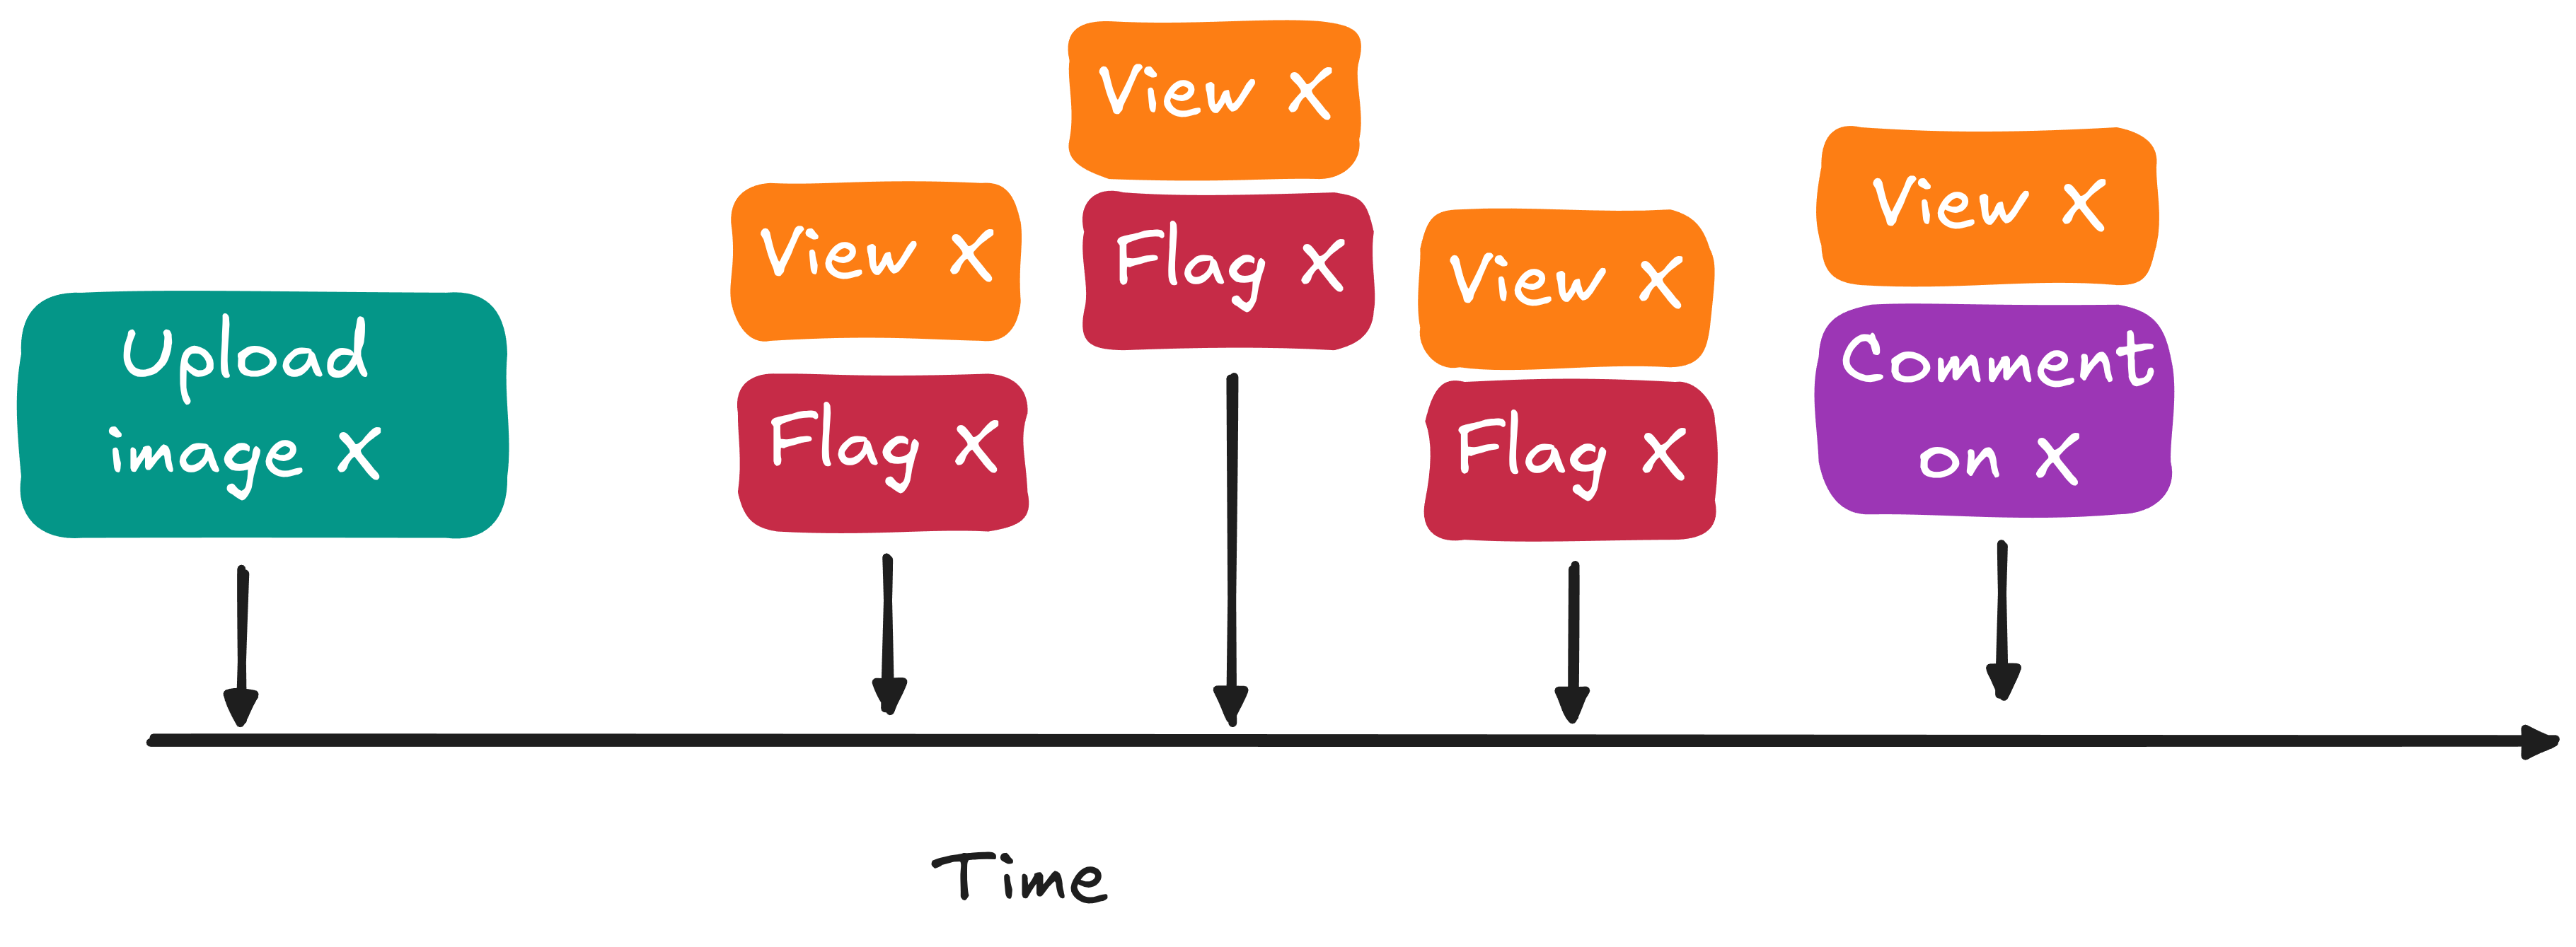

Here is our system view for the real-time phase:

<figure>
<img src="images/realtime-components.png" alt="Real-time architecture" />
<figcaption aria-hidden="true">Real-time architecture</figcaption>
</figure>

From the previous phase, we already have `data_generator`, `api_v1`, PostgreSQL, and MinIO. The newly introduced components are:

-   `api_v2`: streaming-enabled API version (also publishes events to Redpanda), replaces `api_v1`
-   Redpanda + Redpanda Console: event stream broker and UI
-   Redis + Redis Insight: in-memory feature store and UI
-   `stream_consumer`: a custom service that computes rolling windows and emits moderation requests
-   `risk_scoring_service`: a custom service that consumes moderation requests and writes moderation scores
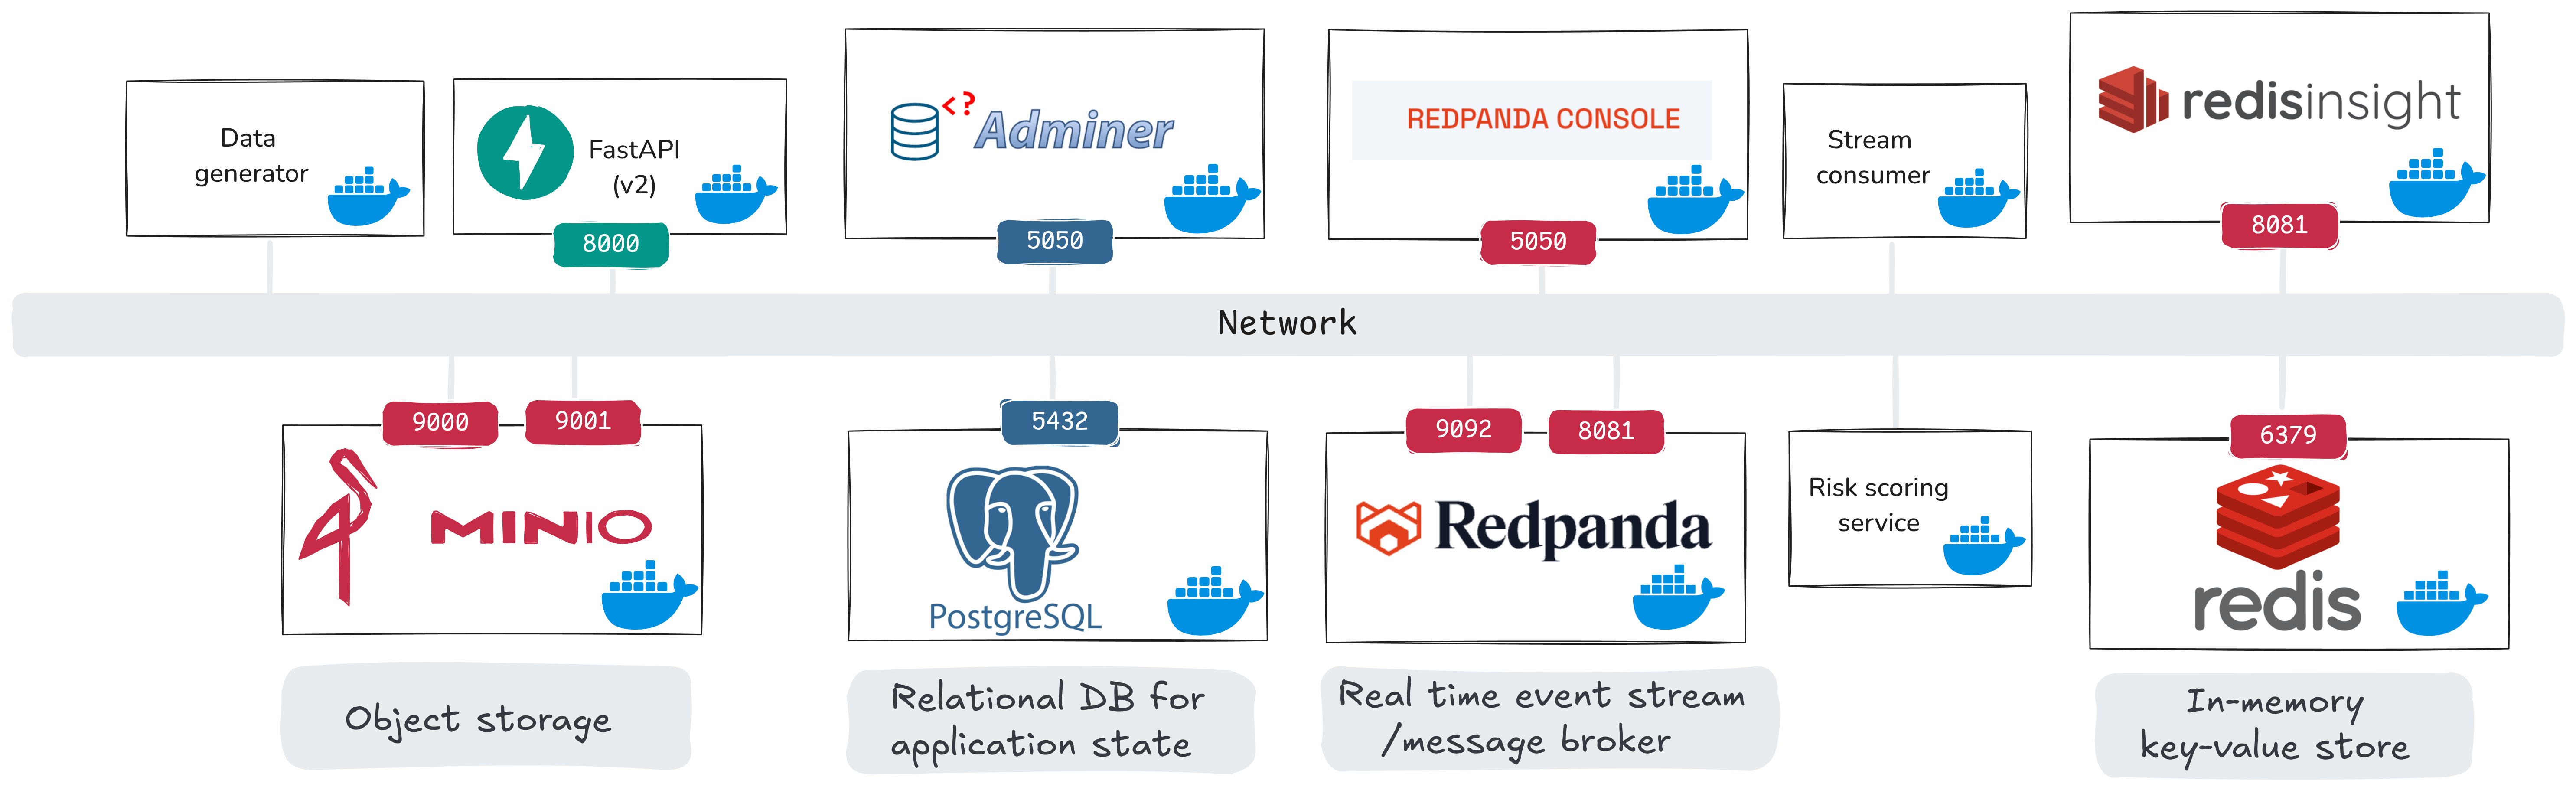

The key Compose blocks for Redpanda and Redis are:

``` yaml
redpanda:
  image: docker.redpanda.com/redpandadata/redpanda:v25.3.7
  container_name: redpanda
  command:
    - redpanda
    - start
    - --kafka-addr internal://0.0.0.0:9092,external://0.0.0.0:19092
    - --advertise-kafka-addr internal://redpanda:9092,external://localhost:19092
    - --pandaproxy-addr internal://0.0.0.0:8082,external://0.0.0.0:18082
    - --advertise-pandaproxy-addr internal://redpanda:8082,external://localhost:18082
    - --schema-registry-addr internal://0.0.0.0:8081,external://0.0.0.0:18081
    - --rpc-addr redpanda:33145
    - --advertise-rpc-addr redpanda:33145
    - --smp 1
    - --memory 1G
    - --mode dev-container
    - --set redpanda.log_retention_ms=2592000000
    - --set redpanda.log_segment_ms=3600000
  ports:
    - "18081:18081"
    - "18082:18082"
    - "19092:19092"
    - "19644:9644"
  healthcheck:
    test: [ "CMD-SHELL", "rpk cluster health | grep -E 'Healthy:.+true' || exit 1" ]
    interval: 15s
    timeout: 3s
    retries: 5

redis:
  image: redis:7-alpine
  container_name: redis
  ports:
    - "6379:6379"
  volumes:
    - redis_data:/data
  healthcheck:
    test: [ "CMD", "redis-cli", "ping" ]
    interval: 5s
    timeout: 3s
    retries: 5
  command: redis-server --appendonly yes
```

The stream consumer Kafka wiring comes from this Compose block:

``` yaml
stream_consumer:
  environment:
    - KAFKA_BOOTSTRAP_SERVERS=redpanda:9092
    - KAFKA_CONSUMER_GROUP=gourmetgram-stream-consumer
    - KAFKA_TOPICS=gourmetgram.views,gourmetgram.comments,gourmetgram.uploads,gourmetgram.flags
    - MODERATION_TOPIC=gourmetgram.moderation_requests
```

And in code, the consumer is initialized with those settings and subscribes to all source topics:

``` python
self.consumer = KafkaConsumer(
    *config.kafka_topics,
    bootstrap_servers=config.kafka_bootstrap_servers,
    group_id=config.kafka_consumer_group,
    auto_offset_reset='earliest',
    enable_auto_commit=config.consumer_auto_commit,
    max_poll_records=config.consumer_max_poll_records,
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
)
```

The stream consumer is where API events are transformed into rolling features and moderation requests. In simplified form:

``` python
for event in kafka_consumer.poll():
    if event["event_type"] == "view":
        process_view_event(event)
    elif event["event_type"] == "comment":
        process_comment_event(event)
    elif event["event_type"] == "flag":
        process_flag_event(event)
```

and

``` python
redis.zadd("image:<id>:views:5min", score=timestamp, member=member)
views_5min = zcount("image:<id>:views:5min")
if views_5min >= VIRAL_THRESHOLD:
    publish("gourmetgram.moderation_requests", {"image_id": image_id, "trigger": "viral"})
```

The risk scoring service (heuristic mode in this stage) reads each moderation request, builds features, and computes a risk score from simple rules:

``` python
if total_flags > 0:
    score += 0.4
if comments_5min > 10:
    score += 0.3
if views_5min > 100:
    score += 0.2
score = min(score, 1.0)
```

Then it persists that score:

``` sql
INSERT INTO moderation (target_type, target_id, inference_mode, model_version, risk_score, trigger_type)
VALUES ('image', :image_id, 'heuristic', NULL, :risk_score, :trigger);
```

Here is the updated data flow including the real-time pipeline:

<figure>
<img src="images/realtime-flow.png" alt="Real-time data flow" />
<figcaption aria-hidden="true">Real-time data flow</figcaption>
</figure>

1.  The **data generator** sends synthetic user activity to our API endpoints (uploads, views, comments, flags).
2.  **`api_v2`** handles each request and does two writes:
    -   write current application state to PostgreSQL (for example, increment `images.views`)
    -   emit an event record to Redpanda
3.  **Redpanda** is the message broker. It stores those event records in ordered topics, so downstream services can read a time-ordered stream of what happened.
4.  A **stream consumer** reads those topics, keeps rolling counts (for example, recent views/comments/flags), and decides if an inference request should be triggered based on some heuristic rules.
5.  The stream consumer writes the rolling features to **Redis** (fast in-memory lookup store) and/or publishes a moderation inference request event to Redpanda.
6.  The **risk scoring service** reads the moderation inference request from Redpanda, fetches the latest rolling features from Redis and other features from PostgreSQL, and computes a risk score.
7.  The risk scoring service writes its output to **PostgreSQL** (`moderation` table), so that it can be used by application logic.

So PostgreSQL keeps durable application and moderation records, Redpanda carries ordered event history, Redis holds the latest fast-changing features, and inference consumes those features to make decisions.
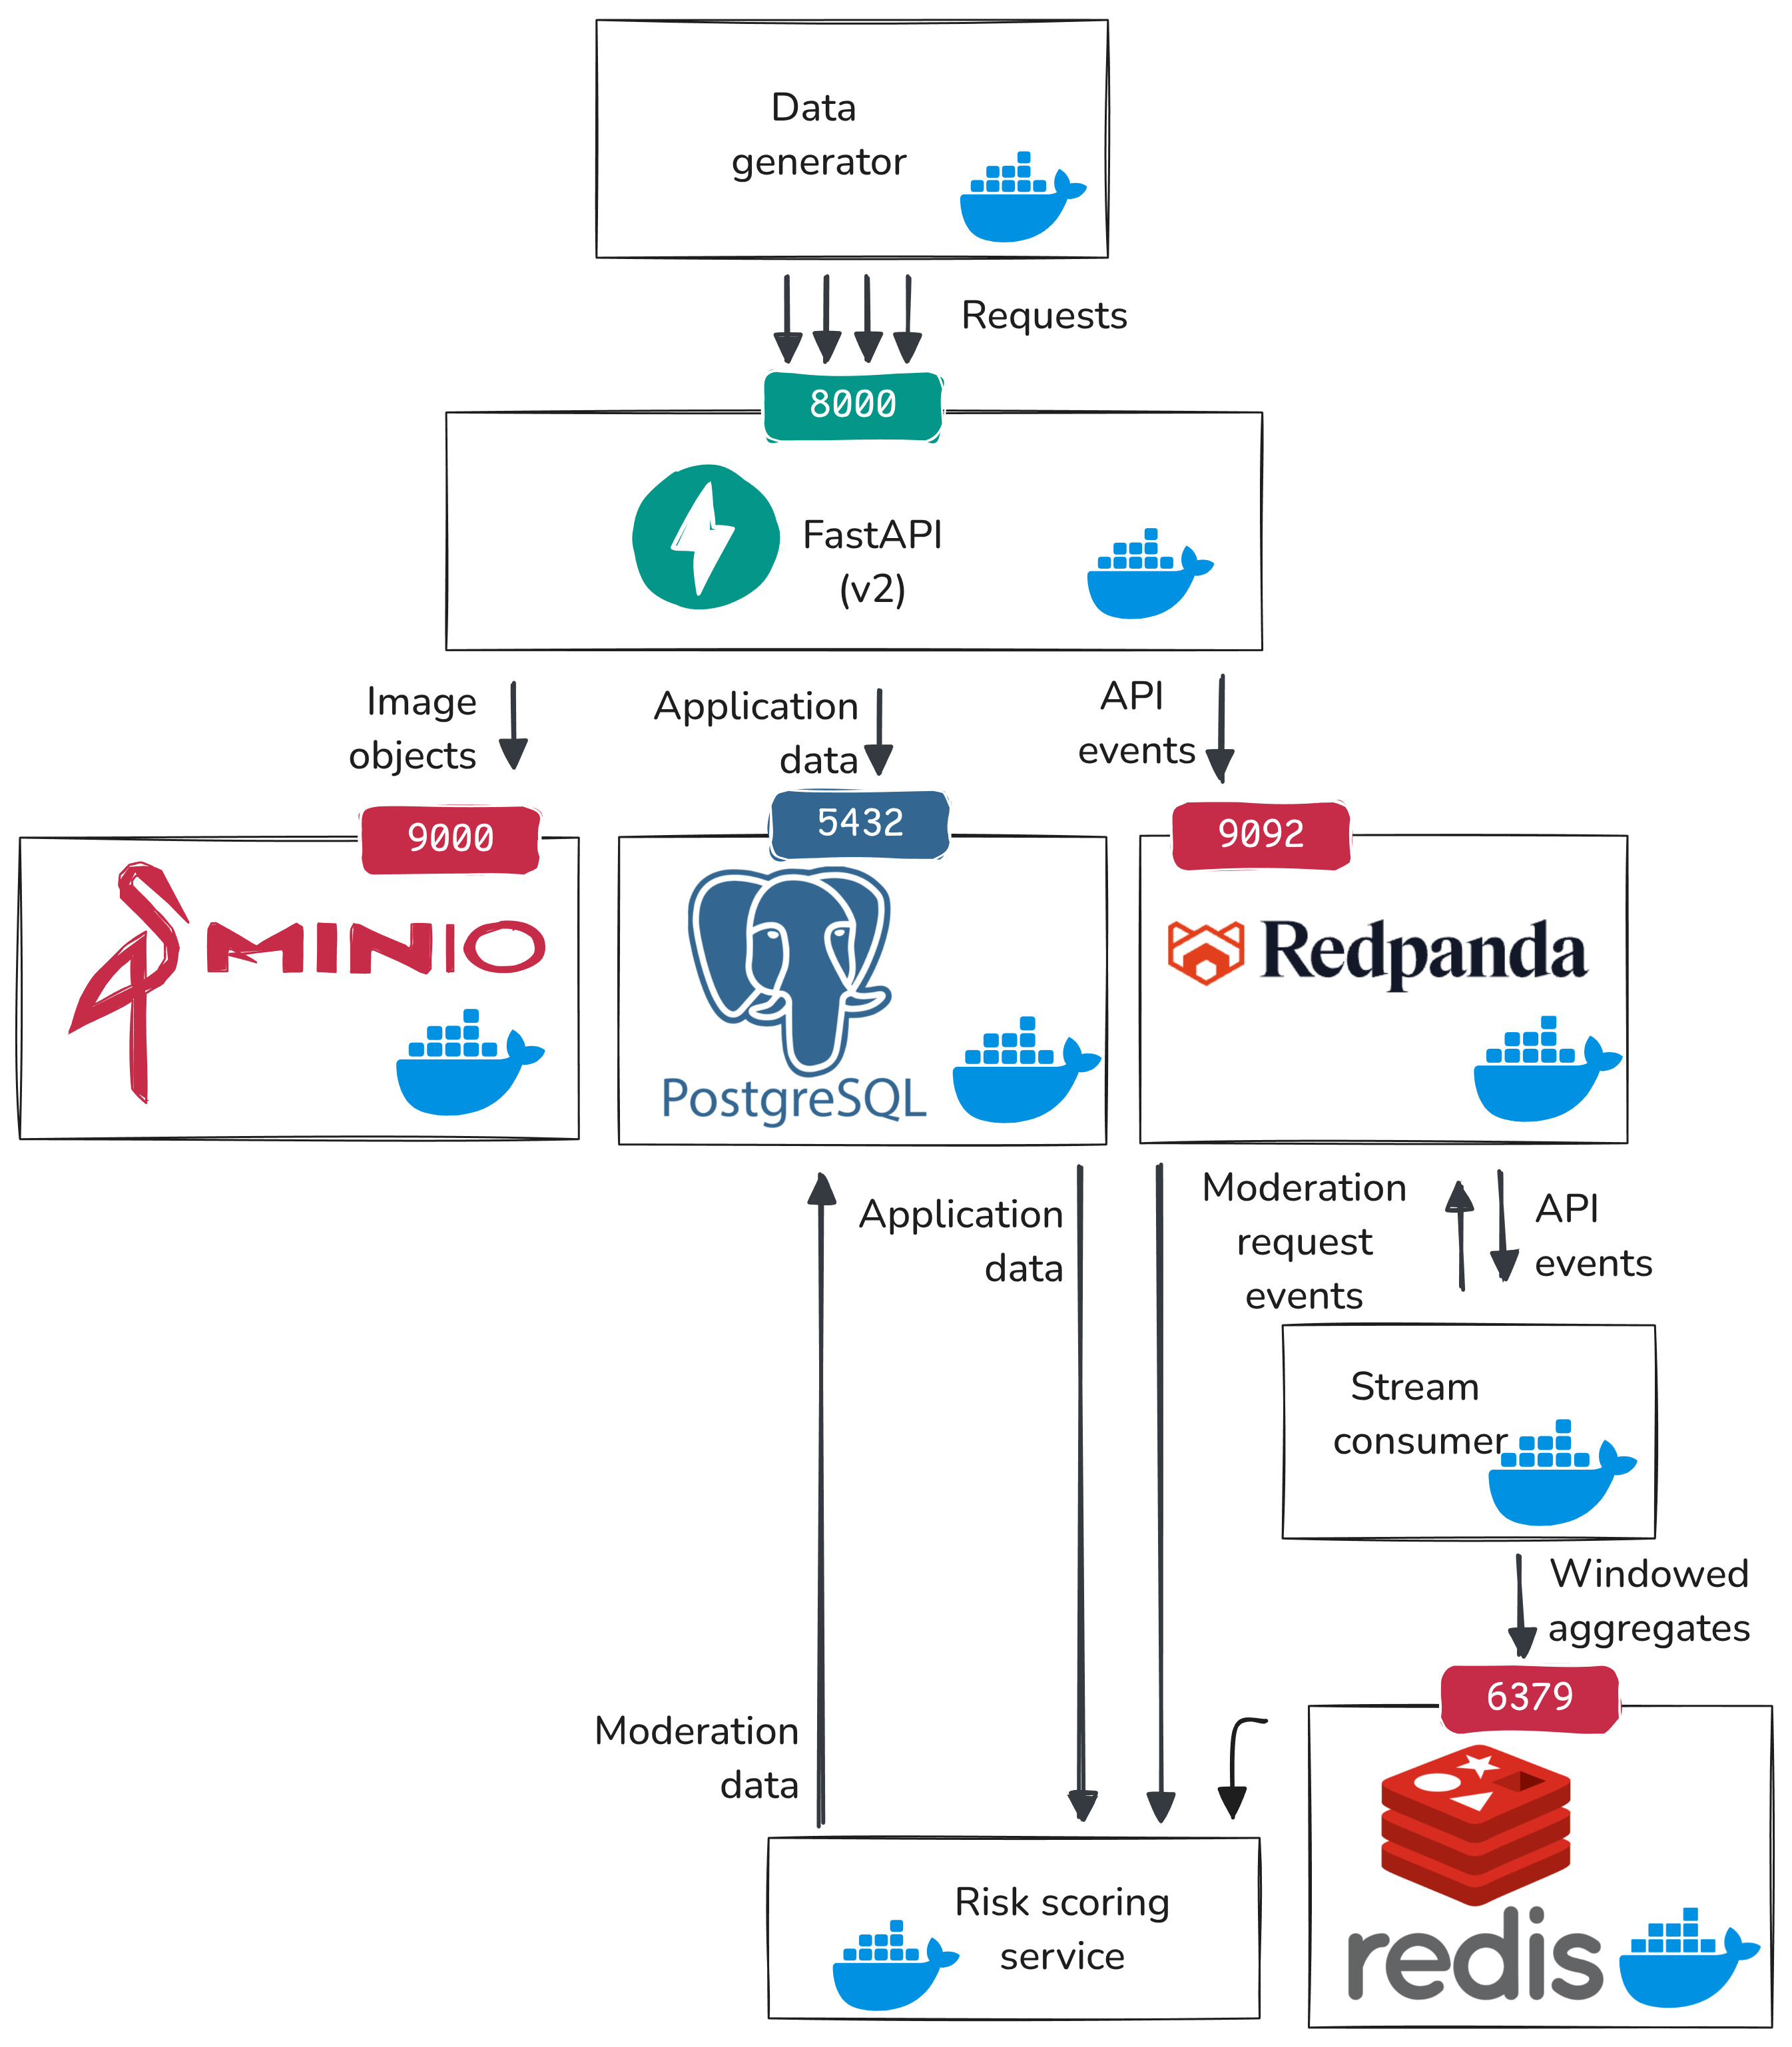

Before we run the real-time services, we should define the inference inputs exactly.

For each moderation request, the risk scoring service builds a 29-dimensional feature vector:

-   **Temporal (4)**: `time_since_upload_seconds`, `hour_of_day`, `day_of_week`, `is_weekend`
-   **Window aggregates (6)**: `views_5min`, `views_1hr`, `comments_5min`, `comments_1hr`, `flags_5min`, `flags_1hr`
-   **Flag count (1)**: `total_flags`
-   **Derived engagement (3)**: `view_velocity_per_min`, `comment_to_view_ratio`, `recent_engagement_score`
-   **Content features (2)**: `caption_length`, `has_caption`
-   **User features (2)**: `user_image_count`, `user_age_days`
-   **Category one-hot (11)**: `category_Bread`, `category_Dairy`, `category_Dessert`, `category_Egg`, `category_Fried`, `category_Meat`, `category_Noodles`, `category_Rice`, `category_Seafood`, `category_Soup`, `category_Veggie`

where:

-   Redis provides rolling window counts, which are also used for the derived engagement metrics.
-   PostgreSQL provides image/user metadata needed to construct temporal, content, and user features.

In the future, we might add fused image embeddings to this input. For now, inference uses only the tabular behavioral and metadata features listed above.

### Step 1: Start the real-time services

Stop `api_v1` and the synthetic generator so we can switch into the real-time stage:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml stop data_generator
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml stop api_v1
```

Now start `api_v2`, the message broker, stream processing, and the risk scoring service:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d \
  api_v2 redpanda redpanda-console redis redisinsight stream_consumer risk_scoring_service
```

and check that services are running with

``` bash
# run on node-data
docker ps
```

Quick check that the running API is the streaming-enabled version:

``` bash
# run on node-data
curl -s http://127.0.0.1:8000/docs
```

Open `http://A.B.C.D:8000/docs`, then:

1.  Click `GET /health`.
2.  Click Try it out.
3.  Click Execute.
4.  In the JSON response body, confirm `kafka_enabled` is present.

Then, bring up the data generator:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d data_generator
```

Now that services are up, we will trace one “suspicious” image through this path: API event -\> Redpanda topics -\> stream consumer windowing in Redis -\> moderation request -\> risk scoring -\> moderation row in PostgreSQL.

### Step 2: Inspect the real-time data flow

Open these UIs (with your own floating IP):

-   Redpanda Console: `http://A.B.C.D:8090`
-   Redis Insight: `http://A.B.C.D:8081`

(Neither Redpanda Console nor Redis Insight requires a username/password in our configuration.)

Our updated API service persists application state to PostgreSQL, but also sends events to Redpanda, which keeps our event stream.

In Redpanda Console:

1.  Click Topics in the left menu.
2.  Click `gourmetgram.views` and confirm that messages appear in the messages panel.
3.  Repeat for `gourmetgram.comments`, `gourmetgram.flags`, and `gourmetgram.uploads`.

You should see events arriving in:

-   `gourmetgram.views`
-   `gourmetgram.comments`
-   `gourmetgram.flags`
-   `gourmetgram.uploads`

Note that “views” in particular are not saved individually in PostgreSQL - only a cumulative count - because they were not needed for application state. But now, downstream services that require individual view counts or aggregated view counts over time windows can get them from the event stream.

Watch the service logs of the stream consumer:

``` bash
# run on node-data
docker logs -f stream-consumer
```

and in another terminal:

``` bash
# run on node-data
docker logs -f risk-scoring-service
```

### Step 3: Force one concrete inference example

In a production system, we would usually emit a moderation request for every new upload, so the risk scoring service can score content immediately from metadata features (for example caption/content metadata and uploader context), then re-score later as engagement signals arrive.

In this lab, to keep the flow simple and easy to trace, we only emit `gourmetgram.moderation_requests` when a heuristic real-time trigger fires: bursts in views/comments/flags.

Trigger a synthetic viral burst so that one moderation request is guaranteed to fire:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml run --rm --no-deps \
  -e GENERATOR_MODE=simulate_viral \
  -e GENERATOR_BURST_VIEWS=110 \
  -e GENERATOR_BURST_COMMENTS=8 \
  -e GENERATOR_BURST_FLAGS=2 \
  data_generator
```

This publishes a burst of view events for one real image. Within a few seconds, the stream consumer should publish a moderation request, and the risk scoring service should produce a decision.

The simulation should print something like:

    Simulating viral burst for image: 123e4567-e89b-12d3-a456-426614174000

with an image ID. Copy the image ID printed by the script. We will call this value `IMAGE_ID`.

### Step 4: Trace one viral item through the real-time flow

Now, you will trace this item through the real-time data flow, and you will take screenshots at each stage.

In the Redpanda Console, which is open at `http://A.B.C.D:8090`, let’s follow the same `IMAGE_ID` across services:

First, in Redpanda Console, click Topics -\> `gourmetgram.views`, then use the message filter/search box to search for `IMAGE_ID` and confirm burst view events arrived.

The stream consumer will have written aggregates to Redis. Open Redis Insight (`http://A.B.C.D:8081`), then in the **Filter by Key Name or Pattern** box type: `image:IMAGE_ID*` (include the trailing `*`). Do this quickly after running the viral burst, because rolling-window keys are time-based and old entries are cleaned up.

In Redis Insight, expand the tree `image` -\> `IMAGE_ID` -\> (`views`, `comments`, `flags`). You will see window keys such as `1hr` and sometimes `5min`.

To interpret what you see in Redis Insight for a sorted-set key (for example `image:IMAGE_ID:flags:1hr`):

-   **Member** is the stored event token. In this lab, it is a string like `flag:<event_timestamp>:<random_suffix>`. Each member corresponds to one event that happened for this image.
-   **Score** is the event timestamp (Unix time, seconds). Redis uses this numeric score to keep members ordered by time and to support window queries.
-   The sorted set itself is the “value” for that key. So for sorted sets, the value is not one scalar number; it is the collection of `(member, score)` pairs.
-   The **Length** shown near the top of the key details panel is the current number of members in that set (that is, event count currently in the window).
-   **TTL** is how long until Redis expires the key. Because these are rolling windows, keys naturally age out.

For keys like `total_flags`, `total_comments`, and `total_views`, the key type is `STRING`; in that case the value is a scalar counter.

This image will have triggered the stream consumer to write an event to `moderation_requests`. In Redpanda Console, click `gourmetgram.moderation_requests` and verify at least one message includes the same `IMAGE_ID`.

The risk scoring service will have read the request from Redpanda, applied a heuristic to compute a risk score, and produced an output. In risk scoring logs (`docker logs -f risk-scoring-service`), confirm the scoring request and stored moderation output for the same `IMAGE_ID`.

In Adminer (`http://A.B.C.D:5050`), log in with `PostgreSQL` / `postgres` / `user` / `gourmetgram_postgres` / `gourmetgram`, then confirm the same `IMAGE_ID` appears in `target_id` for a row in the `moderation` table.